In [8]:
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

from traj_dataset import TrajDataset
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, Adagrad
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)


def posemb_sincos_3d(patches, temperature = 10000, dtype = torch.float32):
    _, f, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    z, y, x = torch.meshgrid(
        torch.arange(f, device=device),
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing='ij')

    fourier_dim = dim // 6

    omega = torch.arange(fourier_dim, device = device) / (fourier_dim - 1)
    omega = 1. / (temperature ** omega)

    z = z.flatten()[:, None] * omega[None, :]
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]

    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos(), z.sin(), z.cos()), dim = 1)

    pe = F.pad(pe, (0, dim - (fourier_dim * 6))) # pad if feature dimension not cleanly divisible by 6
    return pe.type(dtype)


# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim if out_dim else dim),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))


    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear = nn.Linear(1024, 4)

    def forward(self, x):
        x = self.linear(x)

        return x


class SimpleViT(nn.Module):

    def __init__(self, *, image_size=(64, 64), image_patch_size=(16, 16), frames=8, frame_patch_size=4, dim, depth=6, heads=8, mlp_dim=1024,device, channels=1, dim_head=64):
        super().__init__()

        self.device = device

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf)', p1=patch_height, p2=patch_width, pf=frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        ).to(self.device)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim).to(self.device)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 24)
        )


        self.myNet = MyNet().to(device)

        self.decoderLayer = nn.TransformerDecoderLayer(d_model=dim,nhead=heads,batch_first=True).to(self.device)
        self.decoder = nn.TransformerDecoder(self.decoderLayer,depth).to(self.device)

        self.tgt_linear = nn.Linear(4,dim).to(device)


    def forward(self, video,tgt,train=True):
        *_, h, w, dtype = *video.shape, video.dtype
        video = video.to(self.device)


        x = self.to_patch_embedding(video)

        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)

        x = self.generate_sequence(tgt,x,train)
        output = x

        x = self.myNet(x[:, 1:, :])

        if train:
            return x
        else:
            return x,output

    def generate_sequence(self,tgt, memory,train):
        # Initialize the decoder input with a special start-of-sequence token



        if tgt is not None:

            if train:


                tgt = self.tgt_linear(tgt)

                # mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1],device)

                    # Create a tensor of size [10, 1, 1024] containing the SOS token
            sos = torch.ones(10, 1, 1024).to(device)
            # Concatenate the SOS tensor with your original tensor along the sequence length dimension
            tgt = torch.cat([sos, tgt], dim=1)
        else:
            tgt = torch.ones(10, 2, 1024).to(device)

        mask = torch.ones((tgt.shape[0]*8, tgt.shape[1], tgt.shape[1])).to(device)
        mask = mask.masked_fill(torch.tril(torch.ones((tgt.shape[1], tgt.shape[1])).to(device)) == 0, float('-inf'))

        output = self.decoder(tgt=tgt,memory=memory,tgt_mask=mask)

        return output













In [48]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model = SimpleViT(dim=1024,device=device)

    loss_evol = []

    test_loss = []






Using device: cuda


In [11]:
dataset = TrajDataset("64_64_8", img_step=30,test=False,n_prev=8,n_next=8,n_traj=210,device=device)

test_dataset = TrajDataset("64_64_8", img_step=30,test=True,n_prev=8,n_next=8,device=device,n_traj=26)


opening track 0
opening track 1
opening track 2
opening track 3
opening track 4
opening track 5
opening track 6
opening track 7
opening track 8
opening track 9
opening track 10
opening track 11
opening track 12
opening track 13
opening track 14
opening track 15
opening track 16
opening track 17
opening track 18
opening track 19
opening track 20
opening track 21
opening track 22
opening track 23
opening track 24
opening track 25
opening track 26
opening track 27
opening track 28
opening track 29
opening track 30
opening track 31
opening track 32
opening track 33
opening track 34
opening track 35
opening track 36
opening track 37
opening track 38
opening track 39
opening track 40
opening track 41
opening track 42
opening track 43
opening track 44
opening track 45
opening track 46
opening track 47
opening track 48
opening track 49
opening track 50
opening track 51
opening track 52
opening track 53
opening track 54
opening track 55
opening track 56
opening track 57
opening track 58
opening

In [ ]:
batch_size = 10
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
criterion = MSELoss()


"""
for id_b, batch in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        if len(batch["src"]) != batch_size: continue


        X_test = batch["src"]
        Y_test = batch["tgt"]
        TGT = batch["intermediate"]

        seq = []
        future = None
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output


            seq.append(pred)

        seq = torch.cat(seq,dim=1)
        l = criterion(pred,Y_test.to(device))
        test_loss.append(l.item())
"""
optim = Adam(params=model.parameters(),lr=0.001)
for epoch in range(10):
    print("Starting epoch: ", epoch)
    for id_b, batch in enumerate(train_loader):

        if len(batch["src"]) != batch_size: continue

        model.train()
        X_train = batch["src"]
        Y_train = batch["tgt"]
        TGT = batch["intermediate"]


        optim.zero_grad()

        # Teacher forcing
        if epoch % 2 == 0:
             pred = model(X_train.to(device),Y_train.to(device))

        else:
            future = None
            for k in range(8):
                pred,output = model(X_train.to(device),future,train=False)
                future = output

        l = criterion(pred, Y_train[:,:8,:].to(device))
        print(epoch, "-",id_b,"-",l.item())
        loss_evol.append(l.item())
        l.backward()
        optim.step()



        if id_b % 250 == 0:
            print("Testing")
            for id_b, batch in enumerate(test_loader):
                model.eval()
                with torch.no_grad():
                    if len(batch["src"]) != batch_size: continue


                    X_test = batch["src"]
                    Y_test = batch["tgt"]
                    TGT = batch["intermediate"]

                    seq = []
                    future = None
                    for k in range(8):
                        pred,output = model(X_test.to(device),future,train=False)
                        future = output


                        seq.append(pred)

                    seq = torch.cat(seq,dim=1)
                    l = criterion(pred,Y_test[:,:8,:].to(device))
                    test_loss.append(l.item())




Starting epoch:  0
0 - 0 - 1.0717798471450806
Testing
0 - 1 - 41.41667556762695
0 - 2 - 12.160801887512207
0 - 3 - 4.218833923339844
0 - 4 - 0.9965881705284119
0 - 5 - 0.42147180438041687
0 - 6 - 1.1326740980148315
0 - 7 - 0.980944812297821
0 - 8 - 0.3475423753261566
0 - 9 - 0.15235809981822968
0 - 10 - 0.1702975332736969
0 - 11 - 0.3877290189266205
0 - 12 - 0.27845650911331177
0 - 13 - 0.15299421548843384
0 - 14 - 0.2269763946533203
0 - 15 - 0.10186584293842316
0 - 16 - 0.10899784415960312
0 - 17 - 0.11772704124450684
0 - 18 - 0.14954456686973572
0 - 19 - 0.13129985332489014
0 - 20 - 0.17865067720413208
0 - 21 - 0.14111651480197906
0 - 22 - 0.1742127388715744
0 - 23 - 0.1173323392868042
0 - 24 - 0.114218570291996
0 - 25 - 0.1192832961678505
0 - 26 - 0.12234454602003098
0 - 27 - 0.07987182587385178
0 - 28 - 0.0862463116645813
0 - 29 - 0.10263202339410782
0 - 30 - 0.18804065883159637
0 - 31 - 0.1261029839515686
0 - 32 - 0.06243894249200821
0 - 33 - 0.09183431416749954
0 - 34 - 0.1328706

In [105]:
optim = SGD(params=model.parameters(),lr=0.001)
for epoch in range(10):
    print("Starting epoch: ", epoch)
    for id_b, batch in enumerate(train_loader):

        if len(batch["src"]) != batch_size: continue

        model.train()
        X_train = batch["src"]
        Y_train = batch["tgt"]
        TGT = batch["intermediate"]


        optim.zero_grad()

        # Teacher forcing
        if epoch % 2 == 4:
             pred = model(X_train.to(device),Y_train.to(device))

        else:
            future = None
            for k in range(8):
                pred,output = model(X_train.to(device),future,train=False)
                future = output

        l = criterion(pred, Y_train[:,:8,:].to(device))
        print(epoch, "-",id_b,"-",l.item())
        loss_evol.append(l.item())
        l.backward()
        optim.step()



        if id_b % 250 == 0:
            print("Testing")
            for id_b, batch in enumerate(test_loader):
                model.eval()
                with torch.no_grad():
                    if len(batch["src"]) != batch_size: continue


                    X_test = batch["src"]
                    Y_test = batch["tgt"]
                    TGT = batch["intermediate"]

                    seq = []
                    future = None
                    for k in range(8):
                        pred,output = model(X_test.to(device),future,train=False)
                        future = output


                        seq.append(pred)

                    seq = torch.cat(seq,dim=1)
                    l = criterion(pred,Y_test[:,:8,:].to(device))
                    test_loss.append(l.item())

Starting epoch:  0
0 - 0 - 0.012654850259423256
Testing
0 - 1 - 0.00825005304068327
0 - 2 - 0.01154144387692213
0 - 3 - 0.010885508731007576
0 - 4 - 0.012054388411343098
0 - 5 - 0.004200539086014032
0 - 6 - 0.011222593486309052
0 - 7 - 0.004194003529846668
0 - 8 - 0.011803369969129562
0 - 9 - 0.0056694368831813335
0 - 10 - 0.0023996212985366583
0 - 11 - 0.002933518961071968
0 - 12 - 0.006704967003315687
0 - 13 - 0.008540414273738861
0 - 14 - 0.0038089249283075333
0 - 15 - 0.006278200540691614
0 - 16 - 0.006167968735098839
0 - 17 - 0.004364826716482639
0 - 18 - 0.004190427716821432
0 - 19 - 0.004111382644623518
0 - 20 - 0.016464659944176674
0 - 21 - 0.014705550856888294
0 - 22 - 0.008447079919278622
0 - 23 - 0.00491302227601409
0 - 24 - 0.005299839656800032
0 - 25 - 0.008609752170741558
0 - 26 - 0.0033923648297786713
0 - 27 - 0.007414667401462793
0 - 28 - 0.007003859616816044
0 - 29 - 0.003575393930077553
0 - 30 - 0.0031959835905581713
0 - 31 - 0.0020799709018319845
0 - 32 - 0.005642026

KeyboardInterrupt: 

In [12]:
for id_b, batch in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        if len(batch["src"]) != batch_size: continue


        X_test = batch["src"]
        Y_test = batch["tgt"]
        TGT = batch["intermediate"]

        seq = []
        future = None
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output


            seq.append(pred)

        seq = torch.cat(seq,dim=1)
        l = criterion(pred,Y_test.to(device))
        test_loss.append(l.item())


In [ ]:
import numpy as np

print(np.mean(loss_evol))

plt.plot(loss_evol[1000:])
plt.show()

0.028295829770387842


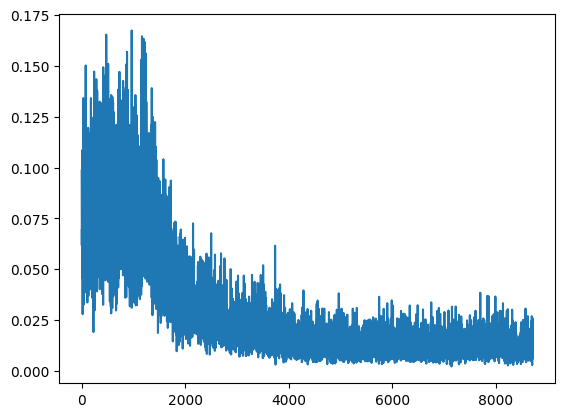

In [102]:
print(np.mean(test_loss[1000:]))
plt.plot(test_loss[1000:])
plt.show()



Test Batch 0
tensor([0.5020, 0.5137, 0.5412, 0.5255, 0.4941, 0.5059, 0.4863, 0.4078, 0.4039,
        0.4314, 0.4627, 0.4471, 0.4235, 0.4627, 0.4824, 0.4353, 0.4667, 0.4588,
        0.4157, 0.4157, 0.4314, 0.3922, 0.4706, 0.6706, 0.6275, 0.7216, 0.7255,
        0.6431, 0.5922, 0.5647, 0.5255, 0.5098, 0.5020, 0.5020, 0.5020, 0.5098,
        0.5137, 0.5020, 0.4784, 0.4588, 0.4588, 0.4824, 0.5137, 0.5373, 0.5490,
        0.5569, 0.5608, 0.5647, 0.5569, 0.5529, 0.5373, 0.5098, 0.4824, 0.4706,
        0.4745, 0.4824, 0.4824, 0.4039, 0.3647, 0.3686, 0.3725, 0.3922, 0.3765,
        0.3137])
tensor([0.2426, 0.5198, 0.2704, 0.5561], device='cuda:0')

[(tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454)), (tensor(571.0099), tensor(1038.5454))]
[(732.3611469268799, 1011.441375732421

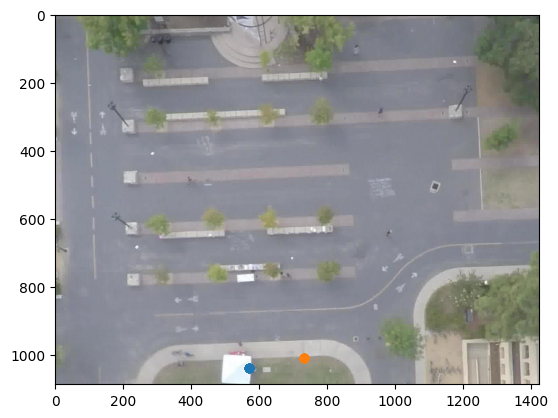

In [108]:
for id_b2, batch_test in enumerate(test_loader):


    with torch.no_grad():
        print(f"Test Batch {id_b2}")
        if len(batch_test["src"]) != batch_size: continue
        model.eval()

        X_test = batch_test["src"]
        Y_test = batch_test["tgt"]
        TGT = batch_test["intermediate"]




        future = None
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output
        print(X_test[0,0,0,:])
        print(pred[0,0,:])

        pred = model(X_test.to(device),Y_test.to(device))



        points = [(k[0]*1424,k[1]*1088) for k in Y_test[7]]
        points2 = [(k[0]*1424,k[1]*1088) for k in pred[7].cpu().detach().numpy()]
        print()
        print(points)
        print(points2)
        print()
        x,y = zip(*points)
        x2,y2 = zip(*points2)

        print(pred.shape)
        print(criterion(pred,Y_test.to(device)))

        plt.scatter([k for k in x],[k for k in y], label="Truth")
        plt.scatter([k for k in x2],[k for k in y2],label="Prediction")
        plt.imread("reference.jpg")
        plt.imshow(plt.imread("reference.jpg"))
        plt.show()
        break
